# Noise learning for QEC

try to use interleaved RB to learn about the H gate, CNOT gate and id gate.

In [5]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

# For simulation
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

FakePerth 是qiskit里面支持的一个模拟器，其中的噪声数据根据具体的在线设备中的数据来生成。

下面我们简单查看一下FakePerth的噪声数据。

In [6]:
FakePerth()._get_noise_model_from_backend_v2()

<NoiseModel on ['sx', 'id', 'reset', 'x', 'measure', 'cx']>

通过交叉随机基准测试，我们尝试去学习在0,1上，0作为控制比特的CNOT的门错误率。

In [7]:
lengths = np.arange(1, 121+1, 30)
num_samples = 100
seed = 1010
qubits = (0, 1)

circ_x = QuantumCircuit(2)
circ_x.cx(0,1)

# The interleaved gate is the CX gate
# circuits.CXGate()
int_exp2 = InterleavedRB(
    circ_x, qubits, lengths, num_samples=num_samples, seed=seed)

int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

CNOT gate's depolarizing param, value, device_components。这个是0，1 CNOT门的退相干噪声。

circuits.CXGate()
alpha_c
0.99065+/-0.00018
[<Qubit(Q0)>, <Qubit(Q1)>]

alpha_c
0.99064+/-0.00017
[<Qubit(Q0)>, <Qubit(Q1)>]

In [8]:
print(int_results2[2])
print(int_results2[2].name)
print(int_results2[2].value)
print(int_results2[2].device_components)

AnalysisResult
- name: alpha_c
- value: 0.99064+/-0.00017
- χ²: 0.7796636788042396
- quality: good
- device_components: ['Q0', 'Q1']
- verified: False
alpha_c
0.99064+/-0.00017
[<Qubit(Q0)>, <Qubit(Q1)>]


Test the interleaved RB experiment can get a good estimate in CNOT

接下来，我们尝试使用学习到的CNOT 值，我们尝试判断该学习到的具体数值的有效性。

In [9]:
from qiskit import QuantumCircuit
# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)

# Test Circuit
# circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

              ░ ┌─┐   
   q_0: ──■───░─┤M├───
        ┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 


In [10]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

backend_noise_model = NoiseModel.from_backend(backend)
backend_noise_model

<NoiseModel on ['sx', 'id', 'reset', 'x', 'measure', 'cx']>

基本信息如下

In [11]:
backend_noise_model._local_quantum_errors.keys()

dict_keys(['id', 'sx', 'x', 'cx', 'reset'])

In [12]:
backend_noise_model.basis_gates

['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']

构建一个存在CNOT和 readout error的错误模型。
其中readout error参考上述模型中。

In [13]:
# Create an empty noise model
noise_model = NoiseModel()

rho = int_results2[2].value.nominal_value
# Add depolarizing error to all single qubit u1, u2, u3 gates
dep_error = depolarizing_error(1-rho, 2)
noise_model.add_quantum_error(dep_error, ['cx'],[0,1])

# add readout error
# NoiseModel.from_backend(backend)._local_readout_errors[(0,)]
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(0,)],[0,])
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(1,)],[1,])

sim_noise = AerSimulator(noise_model = noise_model)

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure', 'cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('cx', (0, 1)), ('measure', (0,)), ('measure', (1,))]


我们尝试用通道，来判断两个CNOT通道的距离。

In [14]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Choi
from qiskit.quantum_info import SuperOp
from qiskit.quantum_info import process_fidelity
from qiskit.quantum_info import hellinger_fidelity
from qiskit.quantum_info import average_gate_fidelity


cx_noise_error = backend_noise_model._local_quantum_errors['cx'][(0,1)]

qc1 = dep_error.to_quantumchannel()
qc2 = cx_noise_error.to_quantumchannel()

# 计算量子通道之间的过程保真度
process_fid = process_fidelity(qc1, qc2)
print("Process Fidelity:", process_fid)

Process Fidelity: 0.9975052565811607


尝试通过运行，查看概率分布的基本情况。

In [15]:
counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%100 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

0


compute the hellinger distance and hellinger_fidelity

In [16]:
from qiskit.quantum_info import analysis, hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum,counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

{'00': 97577, '01': 2633, '10': 1918, '11': 272} {'00': 97901, '01': 2539, '10': 1826, '11': 134}
0.011359304783215465 0.9997419490394069


存在一定的差距，我们尝试判断一下是否是CNOT估计不准确导致的。我们尝试替换掉CNOT的ERROR。

In [17]:
# Create an empty noise model
noise_model_backend = NoiseModel()

noise_model_backend.add_quantum_error(cx_noise_error, ['cx'],[0,1])

# add readout error
# NoiseModel.from_backend(backend)._local_readout_errors[(0,)]
noise_model_backend.add_readout_error(backend_noise_model._local_readout_errors[(0,)],[0,])
noise_model_backend.add_readout_error(backend_noise_model._local_readout_errors[(1,)],[1,])

sim_noise_backend = AerSimulator(noise_model = noise_model_backend)

# Print noise model info
print(noise_model_backend)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure', 'cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('cx', (0, 1)), ('measure', (0,)), ('measure', (1,))]


In [18]:
counts1_sum = {}
counts2_sum = {}
for i in range(1000):
    if i%100 == 0:
        print(i)
    counts1 = sim_noise_backend.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

0
100
200
300
400
500
600
700
800
900


In [19]:
from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum,counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

{'00': 980443, '01': 24309, '10': 18092, '11': 1156} {'00': 980224, '11': 1166, '10': 17911, '01': 24699}
0.0009981807007154908 0.9999980072715702


通过上述结果可以发现，确实是因为CNOT错误学习的不够准确导致的。我们尝试提供m的频率以及采样数量。

理论上m不需要太长，因为我们前面考虑的测量电路也不是很长，只是频率需要提供。

In [20]:
lengths = np.arange(1, 200, 5)
num_samples = 10
seed = 1010
qubits = (0, 1)

circ_x = QuantumCircuit(2)
circ_x.cx(0,1)

# The interleaved gate is the CX gate
# circuits.CXGate()
int_exp2 = InterleavedRB(
    circ_x, qubits, lengths, num_samples=num_samples, seed=seed)

int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

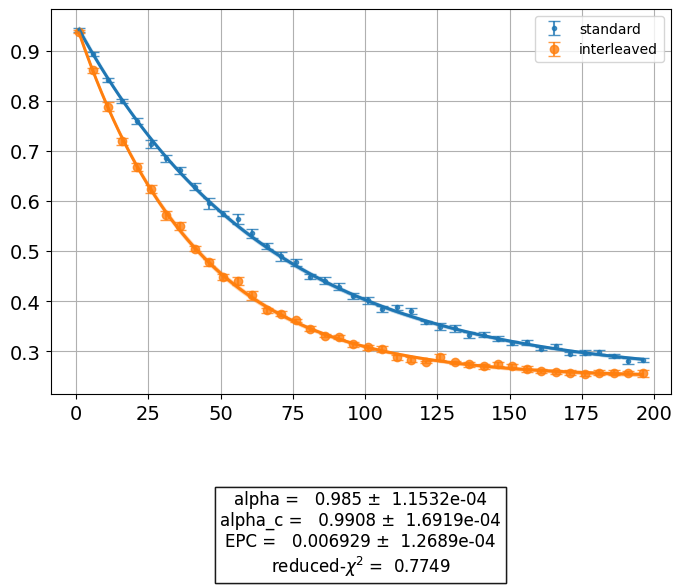

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 20
 - degree of freedom: 76
 - chi-square: 58.893218415952106
 - reduced chi-square: 0.7749107686309488
 - Akaike info crit.: -16.504055031642512
 - Bayesian info crit.: -6.975948492946987
 - init params:
  * a = 0.7031104405608409
  * alpha = 0.9845911715018326
  * b = 0.25
  * alpha_c = 0.9917433564086804
 - fit params:
  * a = 0.7047900569211848 ± 0.0019413167744218001
  * alpha = 0.984960809036316 ± 0.00011531681516634465
  * b = 0.24818612808249615 ± 0.0012816384177624111
  * alpha_c = 0.990760968982986 ± 0.00016918624100594525
 - correlations:
  * (alpha, b) = -0.742741927389275
  * (b, alpha_c) = -0.48500827593844525
  * (a, b) = -0.379821835013433
  * (a, alpha) = -0.017884843037500316
  * (a, alpha_c)

In [21]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

我们重新构建噪声模型

In [22]:
# Create an empty noise model
noise_model = NoiseModel()

# consider down bound - (int_results2[2].value.std_dev)
rho = int_results2[2].value.nominal_value 
print(rho)
# Add depolarizing error to all single qubit u1, u2, u3 gates
dep_error = depolarizing_error(1-rho, 2)
noise_model.add_quantum_error(dep_error, ['cx'],[0,1])

# add readout error
# NoiseModel.from_backend(backend)._local_readout_errors[(0,)]
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(0,)],[0,])
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(1,)],[1,])

sim_noise = AerSimulator(noise_model = noise_model)

0.990760968982986


再次计算CNOT错误的通道的保真度。

In [23]:
cx_noise_error = backend_noise_model._local_quantum_errors['cx'][(0,1)]

qc1 = dep_error.to_quantumchannel()
qc2 = cx_noise_error.to_quantumchannel()

# 计算量子通道之间的过程保真度
process_fid = process_fidelity(qc1, qc2)
print("Process Fidelity:", process_fid)

Process Fidelity: 0.9975215791625915


运行一层的CNOT，查看最终概率分布，以及概率分布的距离和保真度。

In [24]:
from qiskit import QuantumCircuit
# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)

# Test Circuit
# circ.h(0)
for _ in range(1):
    circ.cx(0, 1)
circ.measure_all()
print(circ)

counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

              ░ ┌─┐   
   q_0: ──■───░─┤M├───
        ┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
0
10
20
30
40
50
60
70
80
90
{'00': 97502, '01': 2608, '10': 1987, '11': 303} {'00': 98042, '10': 1764, '01': 2451, '11': 143}
0.013888613183397057 0.9996142500556157


尝试提高电路的深度。

In [25]:
from qiskit import QuantumCircuit
# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)

# Test Circuit
# circ.h(0)
for _ in range(20):
    circ.cx(0, 1)
circ.measure_all()
print(circ)

counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

                                                                              »
   q_0: ──■────■────■────■────■────■────■────■────■────■────■────■────■────■──»
        ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
   q_1: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
meas: 2/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                                       ░ ┌─┐   
«   q_0: ──■────■────■────■────■────■───░─┤M├───
«        ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐
«   q_1: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫─┤M├
«        └───┘└───┘└───┘└───┘└───┘└───┘ ░  ║ └╥┘
«meas: 2/══════════════════════════════════╩══╩═
«                                          0  1 
0
10
20
30
40
50
60
70
80
90
{'01': 6361, '00': 85790, '10': 5854, '11': 4395} {'00': 94070, '10'

这里理论上是能够达到的最优的结果了。

1. 关于利用IRB估计出来的CNOT错误率，通过上述结果发现，该估计的偏高了。
2. 我们尝试增加m以及采样次数，估计概率并没有显著的提高，可能是因为本身的depolarizing_error的通道无法有效模拟该后端的噪声。

For H gate，我们尝试运行上述实验。

In [47]:
lengths = np.arange(1, 200, 5)
num_samples = 10
seed = 1010
qubits = (0,)

# The interleaved gate is the CX gate
int_exp2 = InterleavedRB(
    circuits.HGate(), qubits, lengths, num_samples=num_samples, seed=seed)

int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

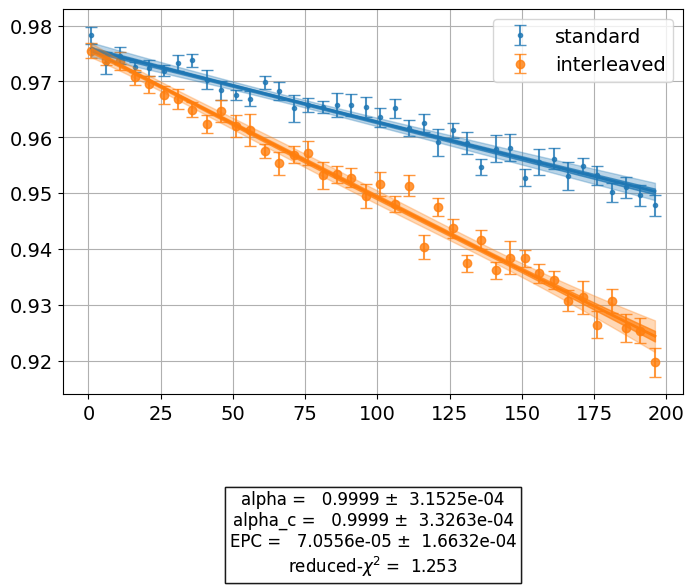

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 345
 - degree of freedom: 76
 - chi-square: 95.19627341192644
 - reduced chi-square: 1.2525825448937689
 - Akaike info crit.: 21.913132921964287
 - Bayesian info crit.: 31.441239460659812
 - init params:
  * a = 0.47711058120193933
  * alpha = 0.999663260762514
  * b = 0.5
  * alpha_c = 0.9996978043890019
 - fit params:
  * a = 0.9758552011664806 ± 2.234951336190883
  * alpha = 0.999864616404323 ± 0.0003152522960879979
  * b = 1.930564430728789e-08 ± 2.235205461188698
  * alpha_c = 0.9998588871310862 ± 0.00033263411044282687
 - correlations:
  * (a, b) = -0.9999999883072455
  * (b, alpha_c) = -0.9999339828878554
  * (alpha, b) = -0.9999263941241165
  * (alpha, alpha_c) = 0.9997988798085848
  * (a, alpha) = 0.9

In [48]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

构建H门的噪声模型

In [49]:
# Create an empty noise model
noise_model = NoiseModel()

# consider down bound - (int_results2[2].value.std_dev)
rho = int_results2[2].value.nominal_value 
print(rho)
# Add depolarizing error to all single qubit u1, u2, u3 gates
dep_error = depolarizing_error(1-rho, 1)
noise_model.add_quantum_error(dep_error, ['h'],[0,])

# add readout error
# NoiseModel.from_backend(backend)._local_readout_errors[(0,)]
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(0,)],[0,])
noise_model.add_readout_error(backend_noise_model._local_readout_errors[(1,)],[1,])

sim_noise = AerSimulator(noise_model = noise_model)

0.9998588871310862


尝试利用transpile_noise_model转换噪声模型，发现作用不大。

In [29]:
# dep_error.to_quantumchannel()

# from qiskit_aer.utils import transpile_noise_model
# new_noise_model = transpile_noise_model(noise_model, basis_gates = backend._basis_gates(), optimization_level =  1)
# # transpile
# new_noise_model._local_quantum_errors['h'][(0,)].to_quantumchannel()

In [50]:
from qiskit import QuantumCircuit
# System Specification
n_qubits = 1
circ = QuantumCircuit(n_qubits)

# Test Circuit
# circ.h(0)
for _ in range(1):
    circ.h(0)
circ.measure_all()
print(circ)

counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

        ┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 
0
10
20
30
40
50
60
70
80
90
{'0': 51143, '1': 51257} {'1': 51115, '0': 51285}
0.0009805585040814533 0.9999980770109645


In [30]:
from qiskit import QuantumCircuit
# System Specification
n_qubits = 1
circ = QuantumCircuit(n_qubits)

# Test Circuit
# circ.h(0)
for _ in range(50):
    circ.h(0)
circ.measure_all()
print(circ)

counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
     q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├»
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
meas: 1/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«     q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├»
«        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«meas: 1/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«     q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├»
«        └───┘└───┘└───┘└───┘└───

10
20
30
40
50
60
70
80
90
{'0': 97706, '1': 4694} {'0': 99919, '1': 2481}
0.042054083268555725 0.9964660359155523


Test tensor single depolarizing or two depolarizing

In [31]:
cx_noise_error = backend_noise_model._local_quantum_errors['cx'][(0,1)]

qc1 = depolarizing_error(1-rho, 2).to_quantumchannel()
qc2 = cx_noise_error.to_quantumchannel()
qc3 = depolarizing_error(1-rho, 1).tensor(depolarizing_error(1-rho, 1))

# 计算量子通道之间的过程保真度
process_fid1 = process_fidelity(qc1, qc2)
process_fid2 = process_fidelity(qc2, qc3)
print("Process Fidelity:", process_fid1)
print("Process Fidelity:", process_fid2)

Process Fidelity: 0.9950914041471208
Process Fidelity: 0.9956600974149262


## Test all H、id、cx gate。

first, we need to consider about the transpile.

因为有一些CNOT不支持直接通过IRB进行学习。IRB支持的两比特门，一般是要符合物理连接的，我们考虑在运行前，把它编译好，放入其中进行测量。

In [32]:
backend._basis_gates

<bound method AerSimulator._basis_gates of AerSimulator(''aer_simulator(fake_perth)'
             noise_model=<NoiseModel on ['sx', 'id', 'reset', 'x', 'measure', 'cx']>)>

In [33]:
print(backend.coupling_map.get_edges())

EdgeList[(6, 5), (5, 6), (4, 5), (5, 4), (3, 5), (5, 3), (3, 1), (1, 3), (2, 1), (1, 2), (0, 1), (1, 0)]


In [34]:
backend.num_qubits

7

In [35]:
def interleaved_rb_QEC(backend, lengths, num_samples, seed):
    
    num_qubits = backend.num_qubits
    
    
    # get couple map for cnot
    coordinate_pairs = backend.coupling_map.get_edges()
    unique_pairs = []
    for pair in coordinate_pairs:
        # 检查反转的边是否已经存在
        if (pair[1], pair[0]) not in unique_pairs:
            # 如果不存在，将边添加到集合中
            unique_pairs.append(pair)
    
    # for H gate
    h_gate_error = {}
    id_gate_error = {}
    cx_gate_error = {}
    
    qec_basis_gate = ['h', 'id', 'cx']
    
    for gate in qec_basis_gate:
        print(f"{gate}")
        if gate == 'h':
            for qubit_id in range(num_qubits):
                qubits = (qubit_id,)
                int_exp2 = InterleavedRB(
                    circuits.HGate(), qubits, lengths, num_samples=num_samples, seed=seed)
                int_expdata2 = int_exp2.run(backend).block_for_results()
                int_results2 = int_expdata2.analysis_results()
                h_gate_error[qubit_id] = int_results2[2].value
                print(f"{qubit_id}_")
        elif gate == 'id':
            for qubit_id in range(num_qubits):
                qubits = (qubit_id,)
                int_exp2 = InterleavedRB(circuits.IGate(), qubits, lengths, num_samples=num_samples, seed=seed)
                int_expdata2 = int_exp2.run(backend).block_for_results()
                int_results2 = int_expdata2.analysis_results()
                id_gate_error[qubit_id] = int_results2[2].value
                print(f"{qubit_id}_")
        elif gate == 'cx':
            for qubit_pairs in unique_pairs:
                int_exp2 = InterleavedRB(circuits.CXGate(), qubit_pairs, lengths, num_samples=num_samples, seed=seed)
                int_expdata2 = int_exp2.run(backend).block_for_results()
                int_results2 = int_expdata2.analysis_results()
                cx_gate_error[qubit_pairs] = int_results2[2].value
                print(f"{qubit_pairs}_")
                
    return h_gate_error, id_gate_error, cx_gate_error, unique_pairs

lengths = np.arange(1, 121+1, 30)
num_samples = 10
seed = 1010
h_gate_error, id_gate_error, cx_gate_error, unique_pairs = interleaved_rb_QEC(backend, lengths, num_samples, seed)

h


0_
1_
2_
3_
4_
5_
6_
id
0_
1_
2_
3_
4_
5_
6_
cx
(6, 5)_
(4, 5)_
(3, 5)_
(3, 1)_
(2, 1)_
(0, 1)_


In [36]:
# backend_noise_model._local_quantum_errors['reset']

In [37]:
# Create an empty noise model
noise_model = NoiseModel()

# consider down bound - (int_results2[2].value.std_dev)

# Add H and id depolarizing error to qubit
for qubit_id, depolarizing_param in h_gate_error.items():
    dep_error = depolarizing_error(1 - depolarizing_param.nominal_value, 1)
    noise_model.add_quantum_error(dep_error, ['h'], [qubit_id,])
for qubit_id, depolarizing_param in id_gate_error.items():
    dep_error = depolarizing_error(1 - depolarizing_param.nominal_value, 1)
    noise_model.add_quantum_error(dep_error, ['id'], [qubit_id,])
for qubit_pairs, depolarizing_param in cx_gate_error.items():
    dep_error = depolarizing_error(1 - depolarizing_param.nominal_value, 2)
    # Because the error about IRB, so we consider the cx error about (0,1) and (1,0) is same.
    noise_model.add_quantum_error(dep_error, ['cx'], qubit_pairs)
    noise_model.add_quantum_error(dep_error, ['cx'], (qubit_pairs[1], qubit_pairs[0]))
    
# add readout error and reset error
# NoiseModel.from_backend(backend)._local_readout_errors[(0,)]
for i in range(backend.num_qubits):
    noise_model.add_readout_error(backend_noise_model._local_readout_errors[(i,)], [i,])
    noise_model.add_quantum_error(backend_noise_model._local_quantum_errors['reset'][(i,)], ['reset'], [i,])

sim_noise = AerSimulator(noise_model = noise_model)

In [38]:
noise_model

<NoiseModel on ['id', 'reset', 'measure', 'h', 'cx']>

In [39]:
backend_noise_model

<NoiseModel on ['sx', 'id', 'reset', 'x', 'measure', 'cx']>

## Consider a sample QEC circuit.

Use the repetitionQubit to test

In [40]:
from qtcodes import RepetitionQubit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer

d:\anaconda\envs\quantum-RB\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


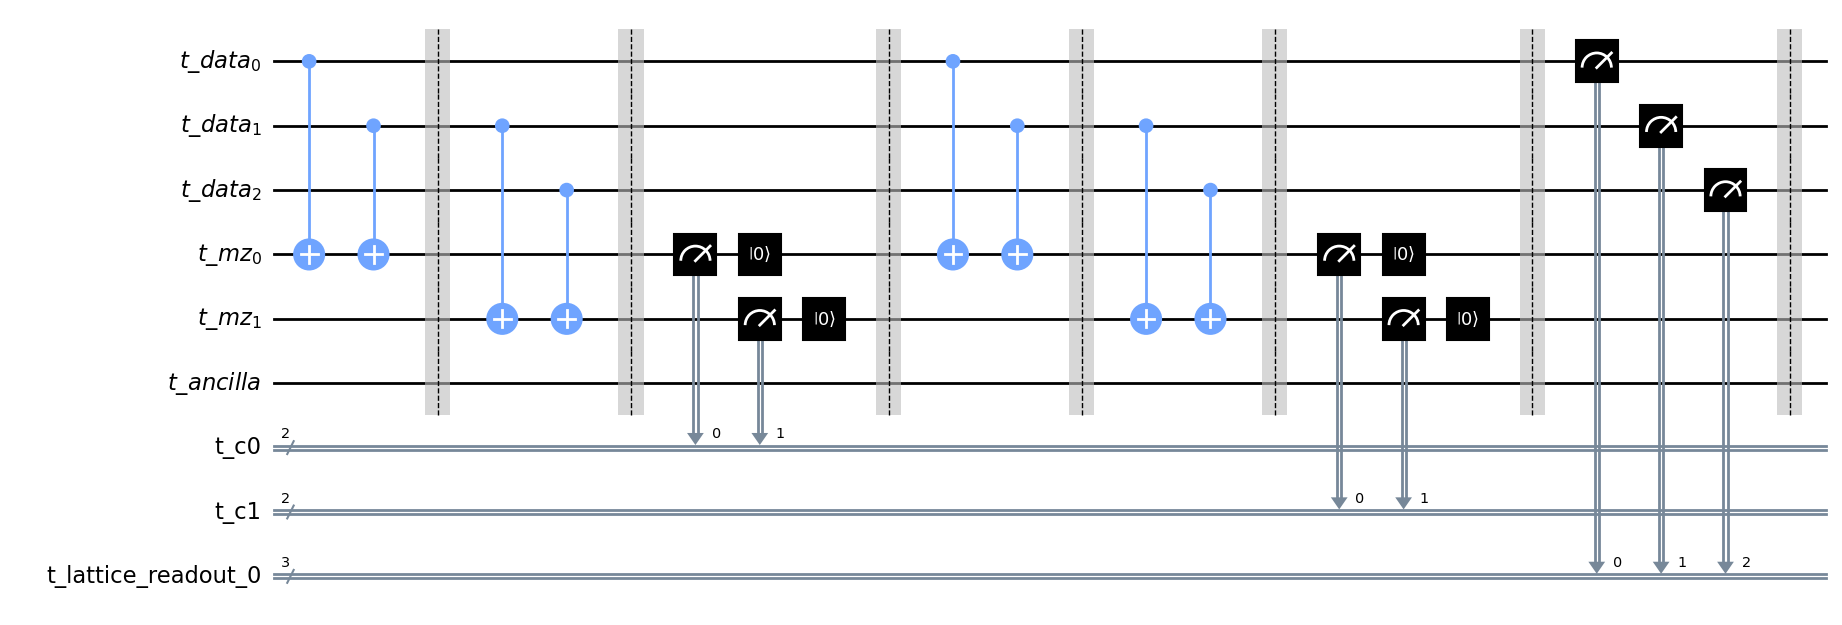

In [41]:
qubit = RepetitionQubit({"d":3},"t")
qubit.stabilize()
qubit.stabilize()
# qubit.x()
qubit.lattice_readout_z()

qubit.draw(output='mpl', fold=150)

In [42]:
results_1 = sim_noise.run(qubit.circ, shots=1).result().get_counts()
results_2 = backend.run(qubit.circ, shots=1).result().get_counts()

readout_string1 = list(results_1.keys())[0]
readout_string2 = list(results_2.keys())[0]
print(readout_string1, readout_string2)

000 00 00 000 00 00


In [43]:
counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

0
10
20
30
40
50
60
70
80
90
{'0': 98499, '1': 3901} {'0': 99937, '1': 2463}
0.028794380856168703 0.9983424546961731


考虑ZZ meas和XX meas

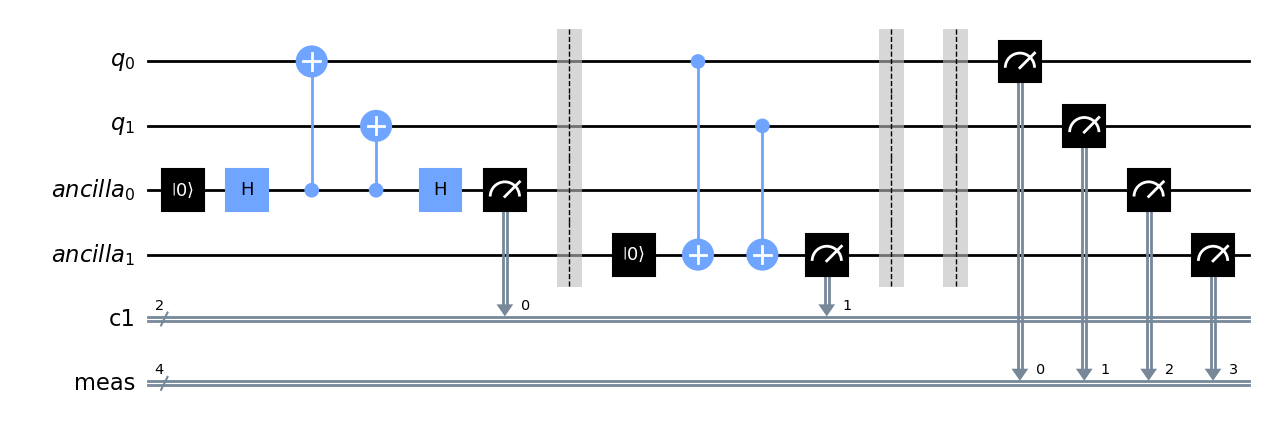

In [44]:
from qiskit.circuit import ClassicalRegister, QuantumRegister

qr = QuantumRegister(2, name='q')
an = QuantumRegister(2, name='ancilla')

rounds = 1
measurements = [ClassicalRegister(2, name="c{}".format(i+1)) for i in range(rounds)]

circ = QuantumCircuit(qr, an, *measurements)

def XX_meas(round, an):
    circ.reset(an[0])
    circ.h(an[0])
    circ.cx(an[0], 0)
    circ.cx(an[0], 1)
    circ.h(an[0])
    circ.measure(an[0], measurements[round][0])
    circ.barrier()

def ZZ_meas(round, an):
    circ.reset(an[1])
    circ.cx(0, an[1])
    circ.cx(1, an[1])
    circ.measure(an[1], measurements[round][1])
    circ.barrier()


for i in range(rounds):
    XX_meas(i, an)
    ZZ_meas(i, an)
circ.measure_all()
    
circ.draw(output='mpl', fold=35)

In [45]:
counts1_sum = {}
counts2_sum = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    counts1 = sim_noise.run(circ,shots = 1024).result().get_counts()
    counts2 = backend.run(circ,shots = 1024).result().get_counts()
    for key, value in counts1.items():
        counts1_sum[key] = counts1_sum.get(key, 0) + value
    for key, value in counts2.items():
        counts2_sum[key] = counts2_sum.get(key, 0) + value

from qiskit.quantum_info import hellinger_distance, hellinger_fidelity
print(counts1_sum, counts2_sum)
hellinger_dis = hellinger_distance(counts1_sum, counts2_sum)

hellinger_fid = hellinger_fidelity(counts1_sum, counts2_sum)
print(hellinger_dis, hellinger_fid)

0
10
20
30
40
50
60
70
80
90
{'0010 00': 993, '1101 11': 175, '0000 00': 22994, '0100 01': 22814, '0111 01': 22764, '1111 01': 337, '0011 00': 23081, '0101 01': 1041, '0011 01': 731, '0100 00': 712, '1011 01': 4, '0001 00': 1034, '0000 01': 661, '1110 11': 157, '0011 10': 295, '0100 11': 303, '1111 11': 75, '0111 00': 764, '0110 01': 1058, '1101 01': 11, '0000 10': 304, '1100 01': 305, '1001 10': 167, '1011 00': 283, '1011 10': 70, '0111 11': 291, '0011 11': 15, '1001 11': 3, '1010 11': 2, '1100 11': 60, '1010 10': 202, '1000 00': 310, '1000 01': 6, '1100 00': 13, '0000 11': 11, '0001 01': 27, '0101 00': 34, '1000 10': 84, '0010 10': 10, '0010 01': 29, '1111 00': 12, '1101 10': 8, '1110 01': 18, '0111 10': 7, '1001 00': 14, '0101 11': 22, '0001 10': 12, '1011 11': 2, '0110 11': 15, '0100 10': 10, '1010 00': 12, '0110 00': 29, '1111 10': 2, '1000 11': 1, '1110 10': 1, '1110 00': 1, '0110 10': 1, '1010 01': 1, '1100 10': 2} {'0010 00': 954, '0100 01': 23026, '1101 11': 127, '0000 00': 23

In [46]:
from scipy.stats import variation

distribution_A = counts1_sum
distribution_B = counts2_sum

# 提取分布的概率向量
probabilities_A = {key: value / sum(distribution_A.values()) for key, value in distribution_A.items()}
probabilities_B = {key: value / sum(distribution_B.values()) for key, value in distribution_B.items()}

# 计算总变差距离
total_variation_distance = sum(abs(probabilities_A.get(key, 0) - probabilities_B.get(key, 0)) for key in set(probabilities_A) | set(probabilities_B))

print("总变差距离：", total_variation_distance)

总变差距离： 0.017851562500000015
